In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: daniilkdd
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:07<00:00, 110MB/s]


In [ ]:
# Основной путь
dataset_path = './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'

# Картика
image_dir = 'images'
# Маска
label_dir = 'masks'

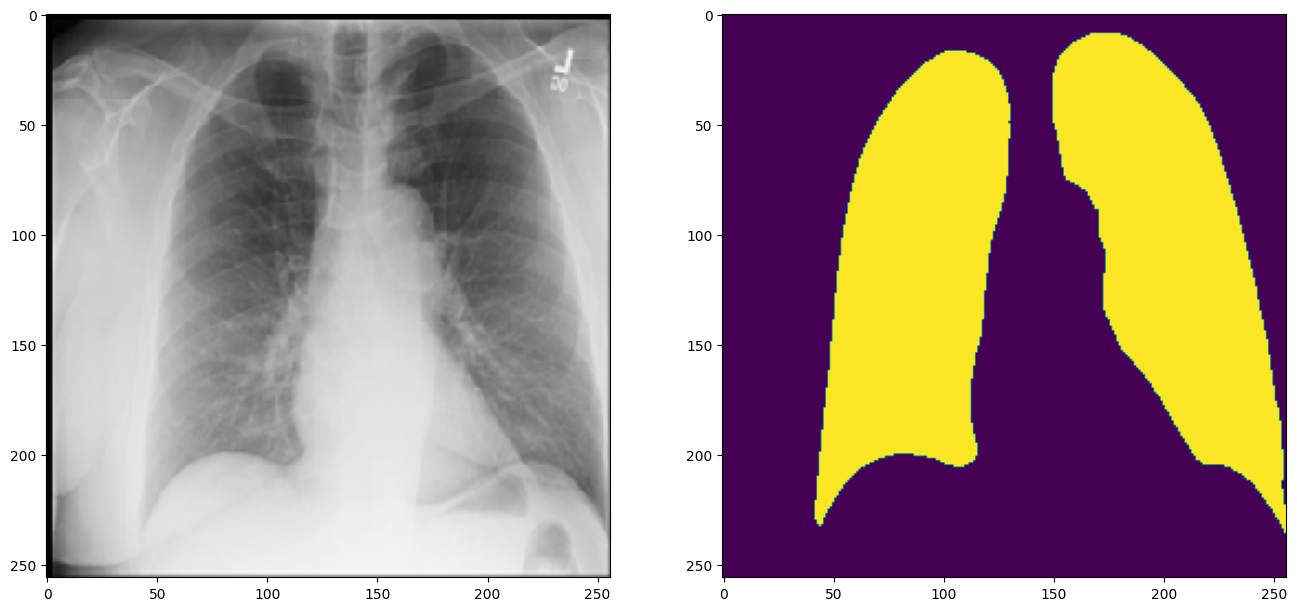

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import  load_img                                       # загрузка изображений

original_image = os.path.join(dataset_path, image_dir, 'Normal-3967.png')       # путь до ориганального изображения
label_image_semantic = os.path.join(dataset_path, label_dir, 'Normal-3967.png') # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # задаем область для построения (канвас)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))   # загружаем оригинальное изображение как RGB с 3 каналами
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))  # загружаем маску как "отеннки серого", т.е. в один канал

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

In [ ]:
# @title Собираем датасет

# Список ссылок на файлы тренировки
input_img_path = sorted(
    [
        os.path.join(dataset_path, image_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, image_dir))
        if fname.endswith(".png")
    ]
)

# Список ссылок на файлы валидационной выборки
target_img_path = sorted(
    [
        os.path.join(dataset_path, label_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, label_dir))
        if fname.endswith(".png")
    ]
)

# Определим batch_size равный 16.
# Как опеределили? Запустили обучение на 8, 16, 32 и посмотрели на точность обучения, скорость обучения и потребляемые ресурсы
# Наиболее оптимальным оказался вариант с размером пакета в 16 образцов
batch_size = 16
img_size = (256, 256)

# 2 класса, потому что маска состоит из 2 цветов
NUM_CLASSES = 2
num_classes = NUM_CLASSES
IMG_SIZE = (256, 256)

In [ ]:
# @title Генератор
import keras                                                                          # библиотека Keras
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)
# Генератор для перебора данных (в виде массивов Numpy)

class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path = None, num_classes = NUM_CLASSES, validation = False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.validation = validation


    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size


    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        # Формируем пакеты из ссылок путем среза длинной в batch_size и возвращаем пакет по индексу
        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        # Создадим массив numpy, заполненный нулями, для входных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 3) и типа данных float32
        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")

        # Создадим массив numpy, заполненный нулями, для выходных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 1) и типа данных uint8
        y = np.zeros((self.batch_size, *self.img_size, num_classes), dtype="uint8")

        # В цикле заполняем массивы с изображениями x и y
        # Перебираем пакеты из путей batch_input_img_path и batch_target_img_path к изображениям
        # zip возвращает для нескольких последовательностей список кортежей из элементов последовательностей с одинаковыми индексами
        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):

            # Загружаем изображение и маску используя путь файловой системы
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))         # 3 канала для изображения
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))  # 1 канал для маски

            if self.validation == False:
                # Применяем аугментацию для проверочной выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
                transform = A.Compose([ # определяем функцию аугментации
                                A.Flip(p=0.5), # Отражение изображения по горизонтали и вертикали
                                A.RandomRotate90(always_apply=False, p=0.5) # Случайный поворот на 90 градусов
                                 ])
                transformed = transform(image=img, mask=mask) # применяем функцию аугментации в изображению и маске
                img = transformed["image"]
                mask = transformed["mask"]

            x[_] = img / 255 # нормализуем изображение
            mask = mask / 255
            y[_] = to_categorical(mask, num_classes=num_classes) # преобразует маску из целых чисел в двоичную матрицу класса

        return x, y


In [ ]:
import random

# Перемешаем данные с одинаковым сидом
seed = 1523
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

In [ ]:
val_samples = 40

# Расщепим наш датасет  на обучающую и проверочные выборки
train_input_img_path = input_img_path[:-val_samples]
train_target_img_path = target_img_path[:-val_samples]
val_input_img_path = input_img_path[-val_samples:]
val_target_img_path = target_img_path[-val_samples:]

In [ ]:
# Создадим экземпляры классов
train_gen = datasetGenerator(batch_size, img_size, train_input_img_path, train_target_img_path, num_classes)
val_gen = datasetGenerator(batch_size, img_size, val_input_img_path, val_target_img_path, num_classes, validation = True)

In [ ]:
# @title Операция свертки
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    acti1 = ReLU()(batch_norm1)


    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = BatchNormalization()(conv2)
    acti2 = ReLU()(batch_norm2)

    return acti2

In [ ]:
# @title Функция кодировщика
# На входе 2 параметра - предыдущий слой и число фильтров (генерируемых карт признаков)
def encoder(entered_input, filters=64):

    MaxPool1 = MaxPooling2D(strides = (2,2))(entered_input)        # зеленый блок
    encod1 = convolution_operation(MaxPool1, filters)  # функция свертки - 2 синих блока
    return encod1 # функция возвращает латеральное соединение и выход из слоя

# Функция декодировщика
# На входе 3 параметра - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder(skip, entered_input, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # красный блок
    Connect_Skip = Concatenate()([skip, Upsample])                                        # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                    # функция свертки - 2 синих блока
    return out # функция возвращает выход из слоя

# Функция декодировщика
# На входе 4 параметра - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder3(skip, skip2, entered_input, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # красный блок
    Connect_Skip = Concatenate()([skip, skip2, Upsample])                                        # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                    # функция свертки - 2 синих блока
    return out # функция возвращает выход из слоя

# Функция декодировщика
# На входе 5 параметров - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder4(skip, skip2, skip3, entered_input, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # красный блок
    Connect_Skip = Concatenate()([skip, skip2, skip3, Upsample])                                        # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                    # функция свертки - 2 синих блока
    return out # функция возвращает выход из слоя

# Функция декодировщика
# На входе 6 параметров - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder5(skip, skip2, skip3, skip4, entered_input, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # красный блок
    Connect_Skip = Concatenate()([skip, skip2, skip3, skip4, Upsample])                                        # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                    # функция свертки - 2 синих блока
    return out # функция возвращает выход из слоя

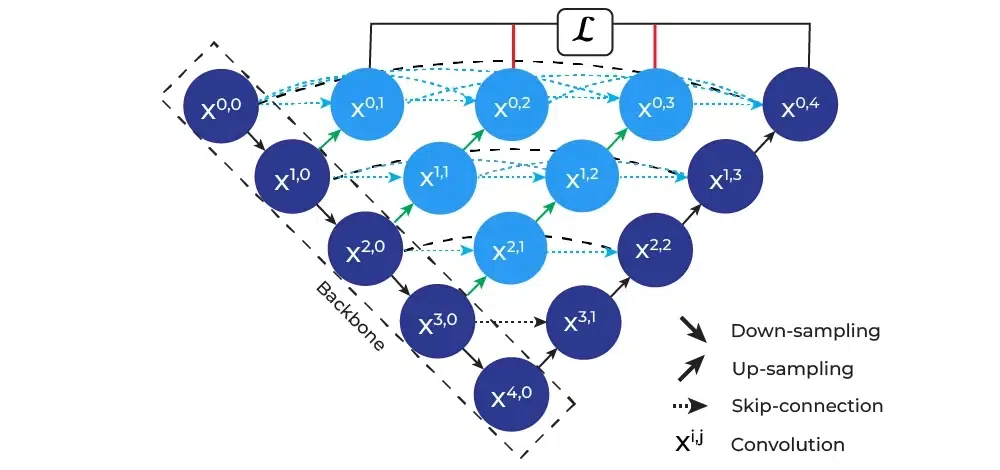

In [ ]:
# Наша интерпретация модели U-net
def U_Net_pp(img_size, num_classes):
    # Входной слой - желтый блок
    inputs = Input(img_size)

    # Задаем блоки кодировщика и латеральные соединения
    x_00 = convolution_operation(inputs, 64)
    x_10 = encoder(x_00, 64*2)
    x_20 = encoder(x_10, 64*4)
    x_30 = encoder(x_20, 64*8)
    x_40 = encoder(x_30, 64*16)


    # Заполняем голубые кружки
    x_01 = decoder(x_00, x_10, 64)
    x_11 = decoder(x_10, x_20, 64*2)
    x_21 = decoder(x_20, x_30, 64*4)
    x_31 = decoder(x_30, x_40, 64*8)

    x_02 = decoder3(x_00, x_01, x_11, 64)
    x_12 = decoder3(x_10, x_11, x_21, 64*2)
    x_22 = decoder3(x_20, x_21, x_31, 64*4)

    x_03 = decoder4(x_00, x_01, x_02, x_12, 64)
    x_13 = decoder4(x_10, x_11, x_12, x_22, 64*2)

    x_04 = decoder5(x_00, x_01, x_02, x_03, x_13, 64)


    # Выходной слой (фиолетовый блок), его конфигурация зависит от решаемой задачи
    outputs = Conv2D(num_classes, kernel_size = (1, 1), padding="same", activation="softmax")(x_04)

    model = Model(inputs, outputs)
    return model

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, ReLU
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from keras.models import Model
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3) # размер к которому преобразуем изображение, 3 канала - RGB
model = U_Net_pp(input_shape, num_classes) # инициализируем модель

In [ ]:
model.compile(
    optimizer='adam' ,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True)
]

In [ ]:
model.summary() # отчет о структуре модели

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 36,187,202 (138.04 MB)

 Trainable params: 36,172,610 (137.99 MB)

 Non-trainable params: 14,592 (57.00 KB)

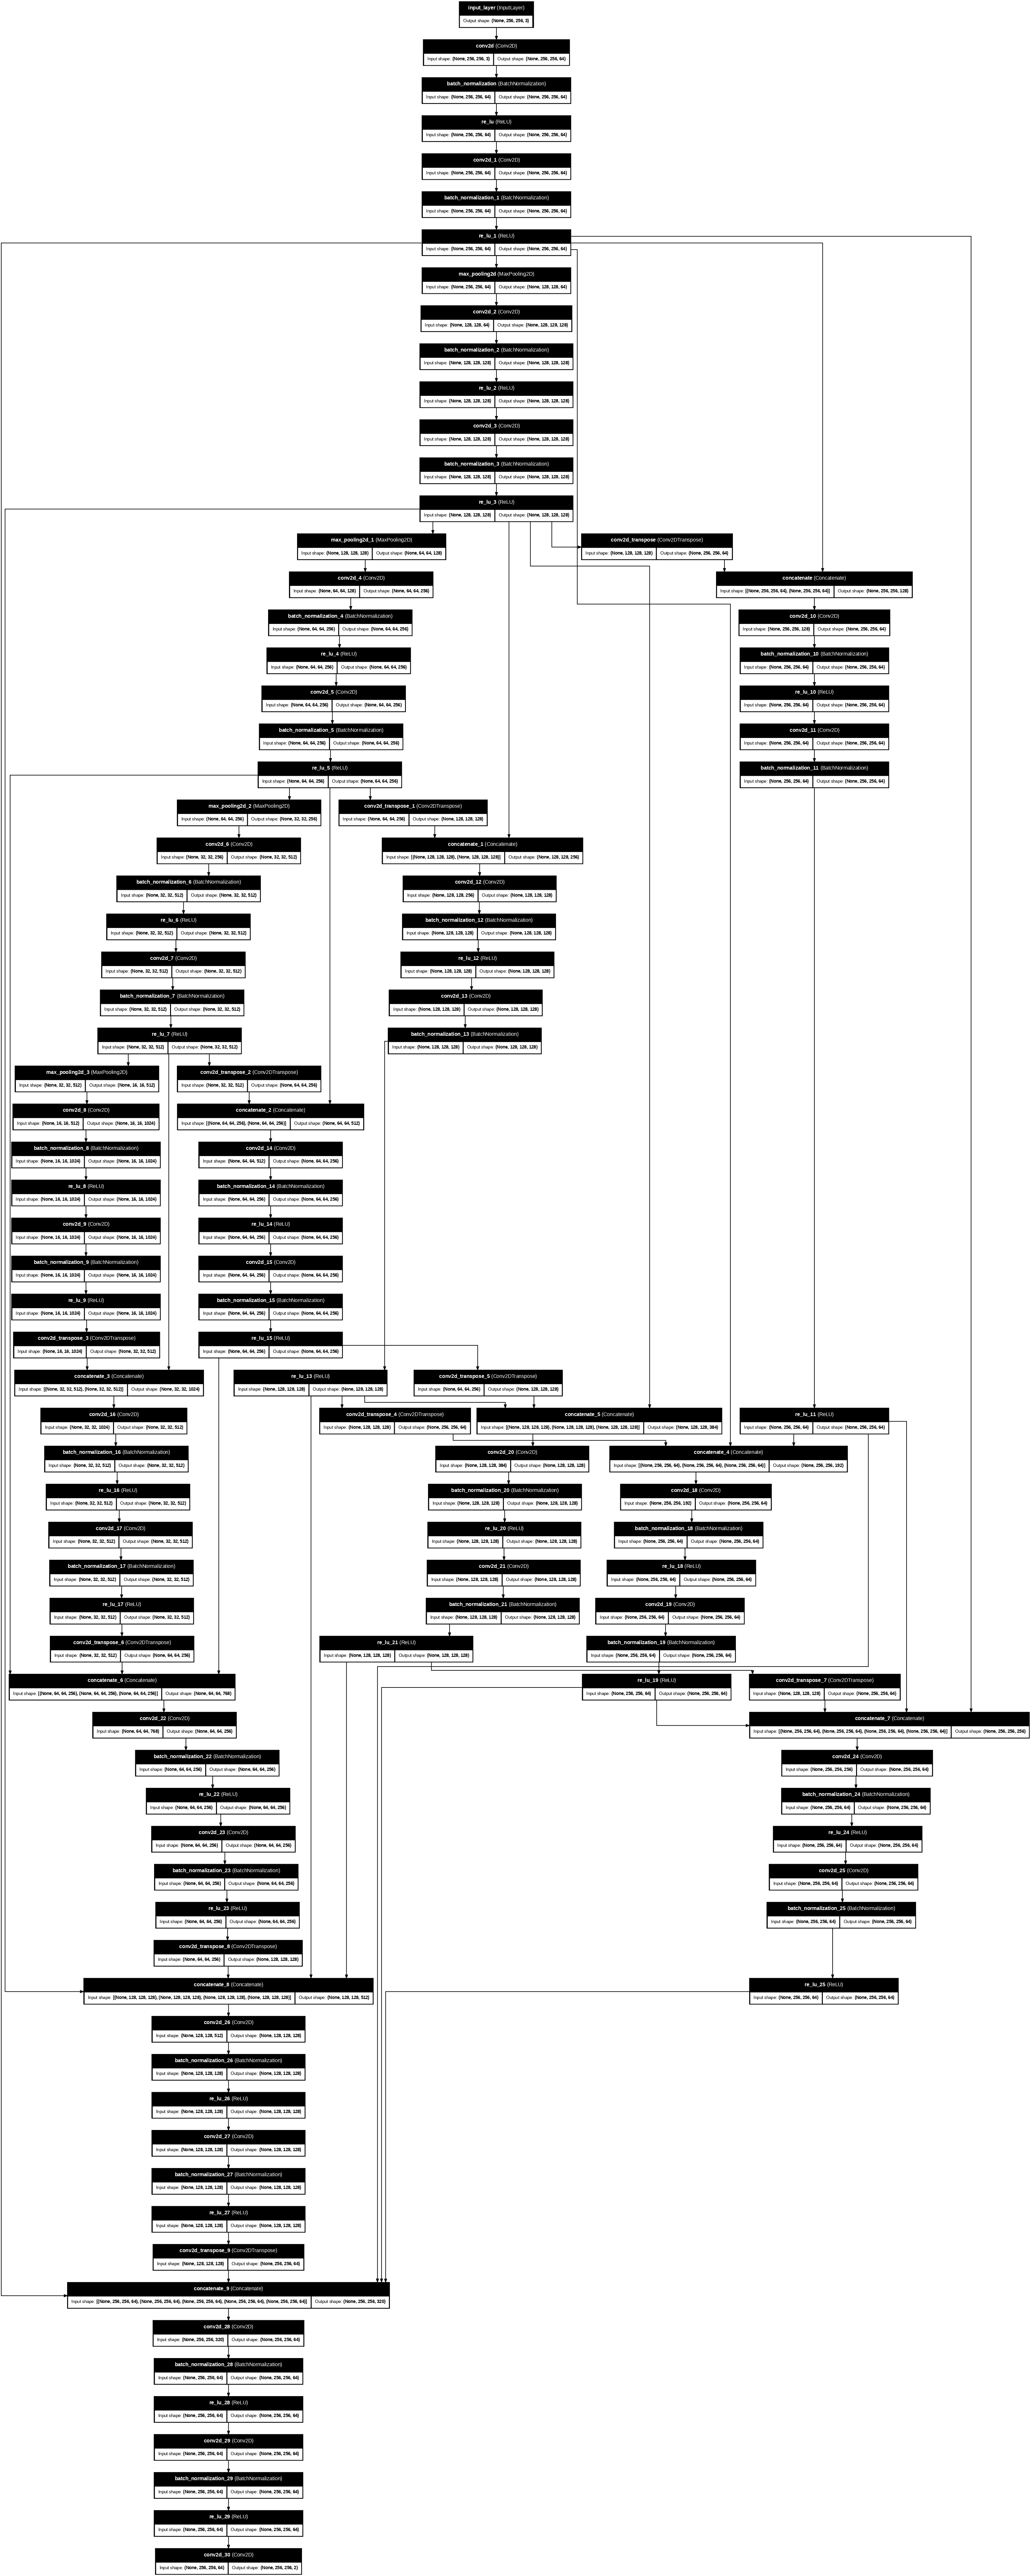

In [ ]:
import tensorflow as tf
# график структуры модели
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

In [ ]:
epochs = 4
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks
                   )

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


634/634 ━━━━━━━━━━━━━━━━━━━━ 1617s 2s/step - accuracy: 0.9319 - loss: 0.1669 - val_accuracy: 0.9854 - val_loss: 0.0412
Epoch 2/4
634/634 ━━━━━━━━━━━━━━━━━━━━ 1486s 2s/step - accuracy: 0.9899 - loss: 0.0260 - val_accuracy: 0.9102 - val_loss: 0.5220
Epoch 3/4
634/634 ━━━━━━━━━━━━━━━━━━━━ 1454s 2s/step - accuracy: 0.9915 - loss: 0.0222 - val_accuracy: 0.9925 - val_loss: 0.0179
Epoch 4/4
634/634 ━━━━━━━━━━━━━━━━━━━━ 1464s 2s/step - accuracy: 0.9934 - loss: 0.0164 - val_accuracy: 0.9943 - val_loss: 0.0136


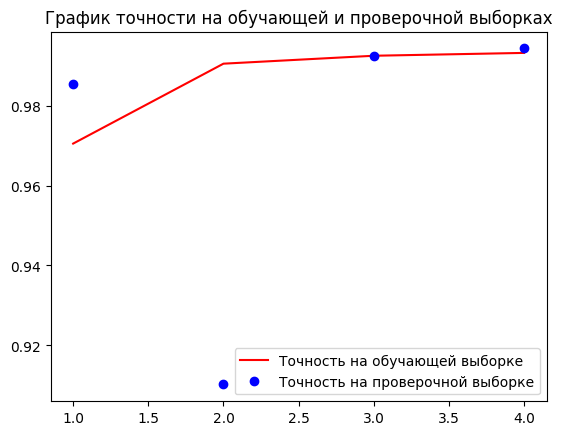

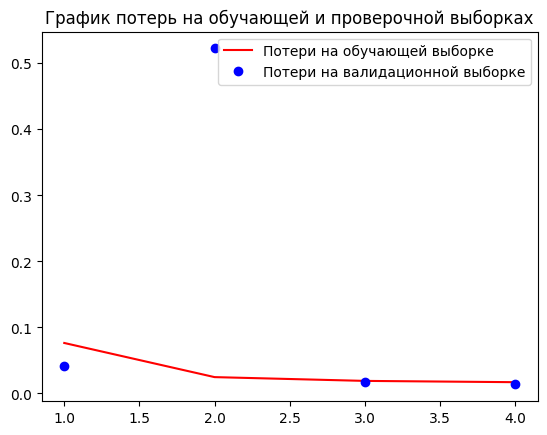

In [ ]:
acc = history.history['accuracy']                              # данные о точности на обучающей выборке
val_acc = history.history['val_accuracy']                      # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0])            # отображаем картинку
    plt.imshow(display_list[i],alpha=0.8)  # отображаем маску с прозрачностью 50%
    plt.axis('off')
  plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


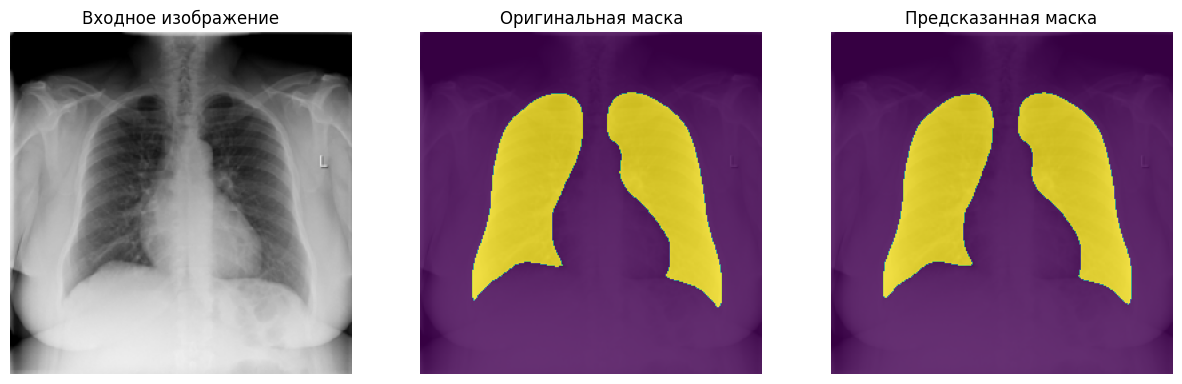

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


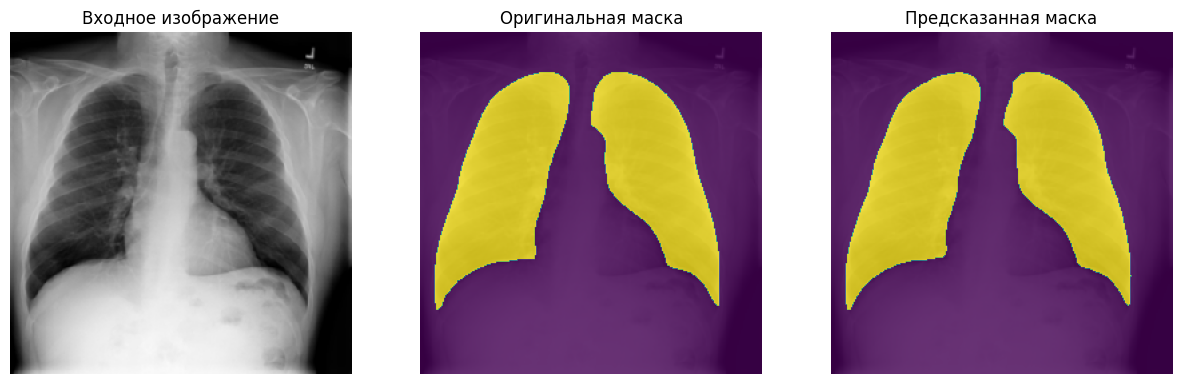

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


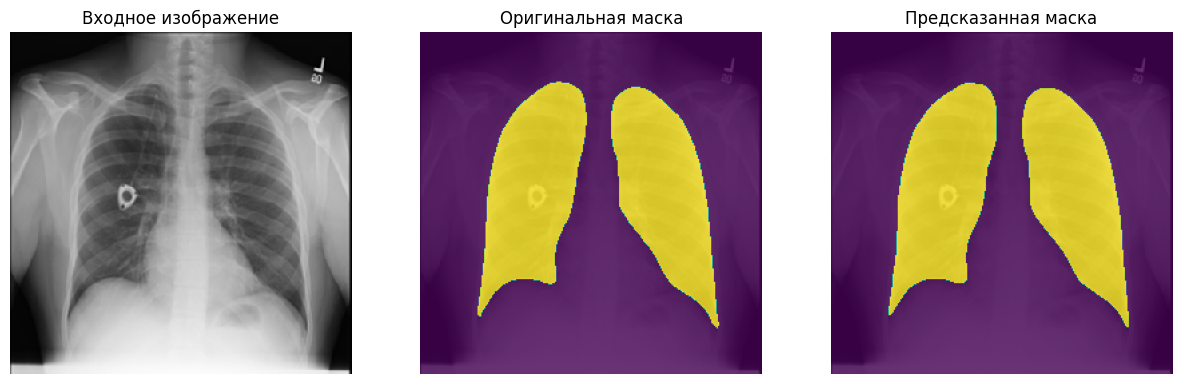

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


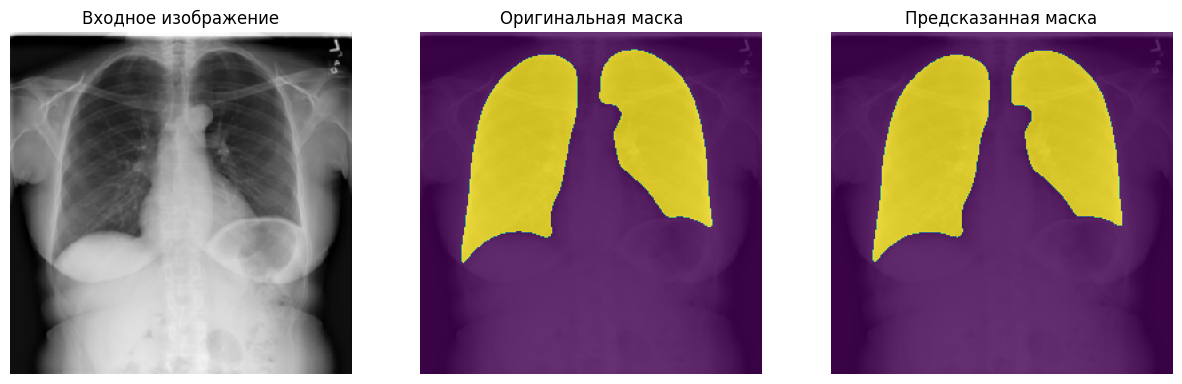

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


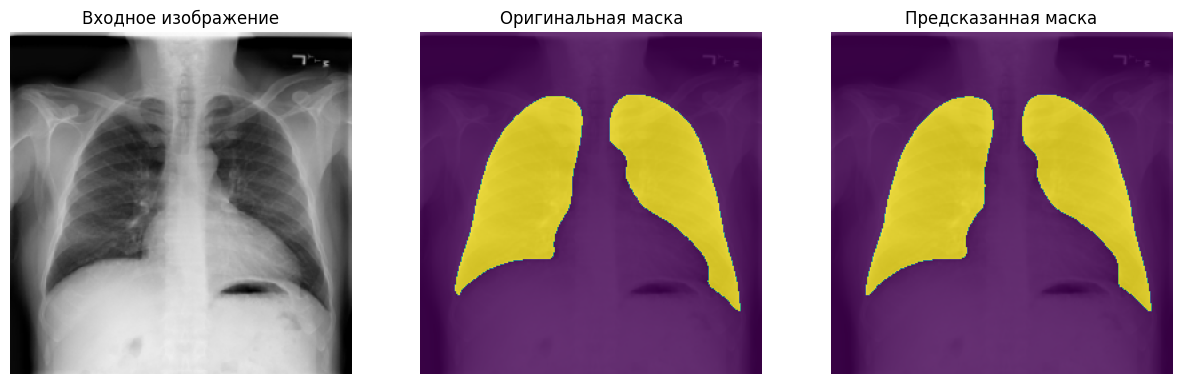

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


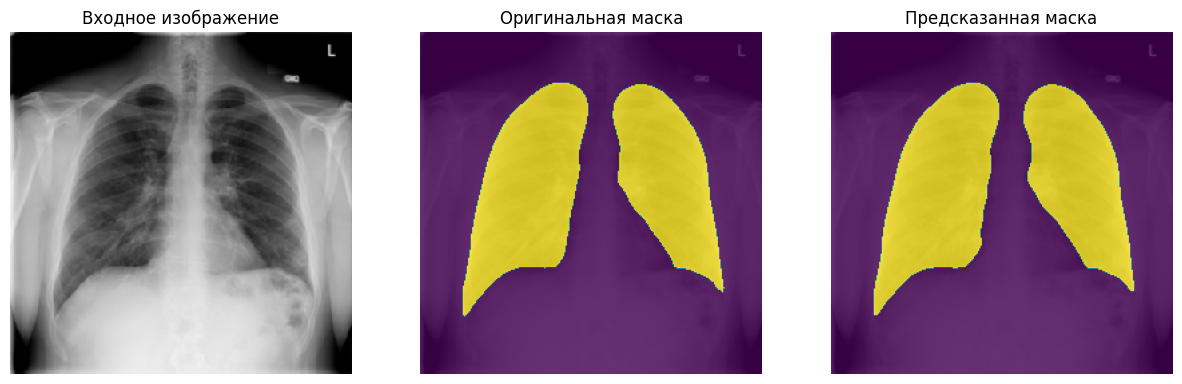

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


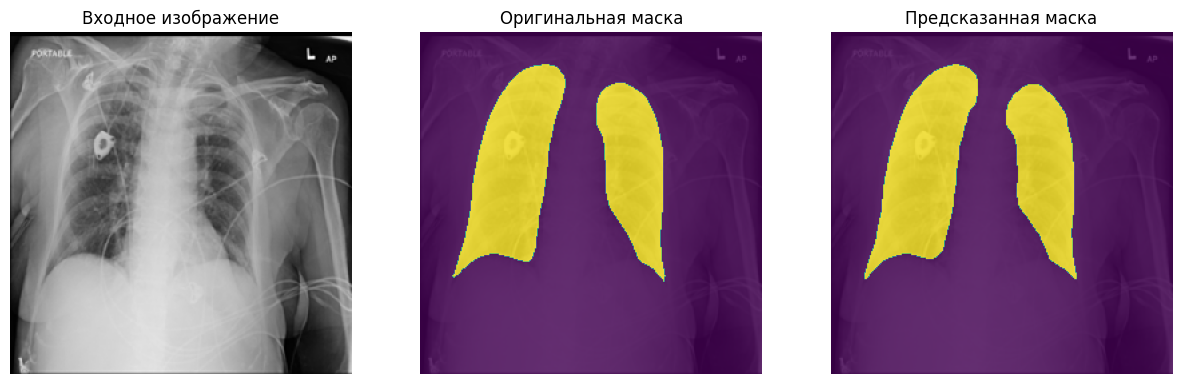

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


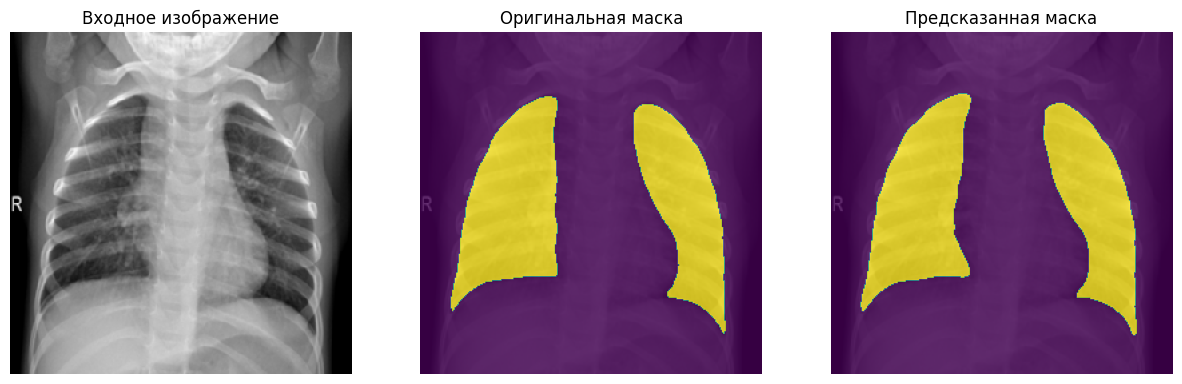

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


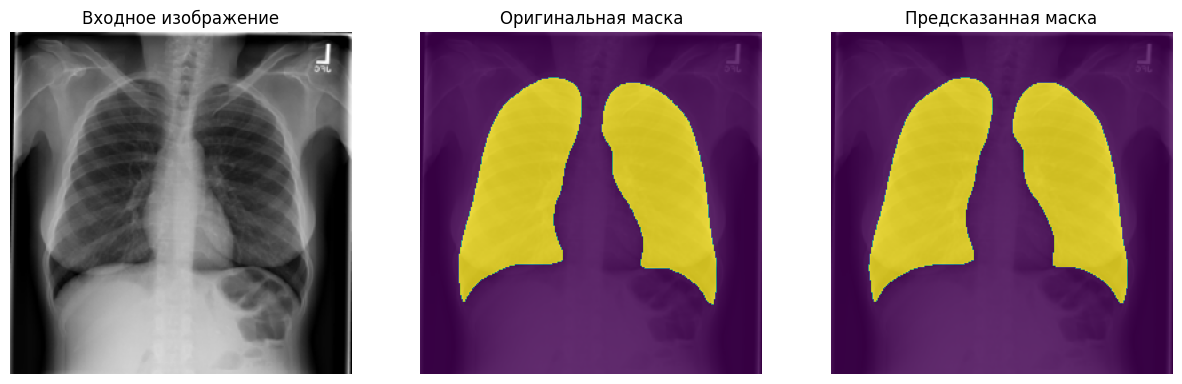

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


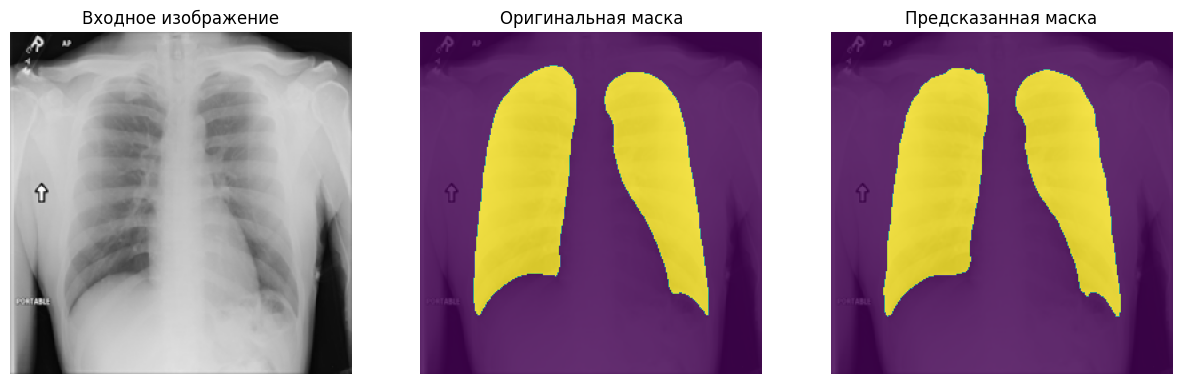

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


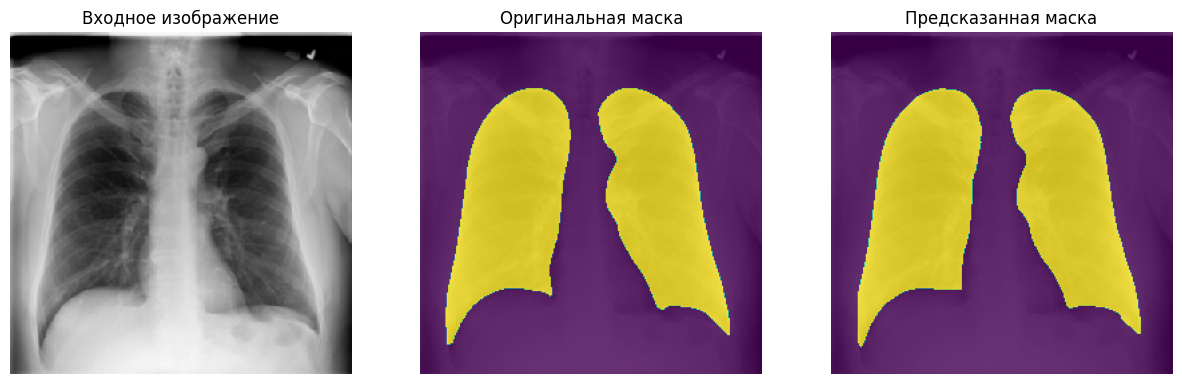

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


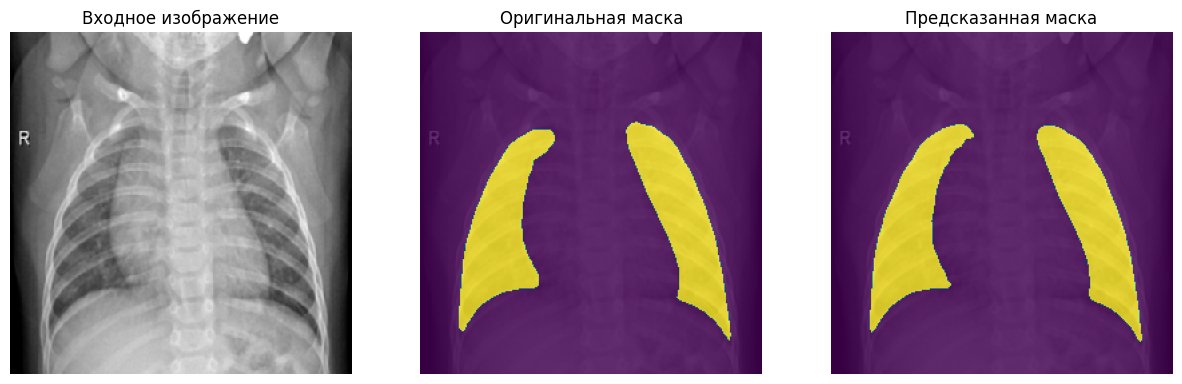

In [ ]:
for index in range(12):                  # выбираем 12 картинок и выводим их в цикле
    img = np.array(load_img(val_input_img_path[index], target_size=(256, 256), color_mode='rgb')) # загружаем картинку для предсказания
    mask = np.array(load_img(val_target_img_path[index], target_size=(256, 256), color_mode='grayscale')) # загружаем маску для сравнения с предсказанием

    # Запускаем модель в режиме предсказания
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Выбираем наиболее веротный класс
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 256, 256, 3)[0], mask, test[0]])  # передаем в функцию display изображение, оригинальную маску и предсказанную